# BERT Model Evaluation
This notebook demonstrates the comprehensive evaluation features of the BERT model for spam detection.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer

from models.bert import SpamBERT
from utils.functions import load_glove_embeddings, build_vocab

In [2]:
ROOT_PATH = '../'
DATA_PATH = os.path.abspath(os.path.join(ROOT_PATH, '../spam-detection-data/'))
DATA_PATH

'/home/michael/PycharmProjects/spam-detection-data'

In [3]:
GLOVE_PATH = os.path.join(DATA_PATH, 'data/raw/glove.6B/glove.6B.300d.txt')
GLOVE_PATH

'/home/michael/PycharmProjects/spam-detection-data/data/raw/glove.6B/glove.6B.300d.txt'

In [4]:
# Load the data
train_df = pd.read_pickle(DATA_PATH + '/data/processed/train.pkl')
test_df = pd.read_pickle(DATA_PATH + '/data/processed/test.pkl')

In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
# Build vocabulary and load embeddings
set_seed(42)
word2idx, idx2word = build_vocab(train_df['text'])
embedding_dim = 300
max_len = 200

In [8]:
pretrained_embeddings = load_glove_embeddings(GLOVE_PATH, word2idx, embedding_dim)

In [9]:
# Load tokenizer and model
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
model = SpamBERT(bert_model_name=bert_model_name)
model.load(os.path.join(DATA_PATH, 'trained_models', 'spam_bert.pt'))
model = model.to(device)
model.eval()

SpamBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

## 1. Comprehensive Performance Metrics

Here we implement the evaluation metrics from Section 3.5.1 of the thesis.

In [12]:
from utils.bert_evaluation import evaluate_model, compute_metrics

# Run evaluation
predictions, labels = evaluate_model(model, test_df, tokenizer)
metrics = compute_metrics(predictions, labels)

# Display results
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

  0%|          | 0/38 [00:00<?, ?it/s]

accuracy: 0.9760
precision: 0.9443
recall: 0.9816
f1: 0.9626
auc_roc: 0.9972
spam_catch_rate: 0.9816
ham_preservation_rate: 0.9735


## 2. Explainability Analysis

Implementing explainability metrics from Section 3.5.2 of the thesis.

/home/michael/PycharmProjects/spam_detection2/utils/bert_evaluation.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Analyzing text: re ilug dial on demand on wed aug 21 2002 at 02 52 11pm 0800 133359ba82f002eb58fc8cb5aa5d7d5c3e4d118 ...

Visualizing attention weights for layer 12:


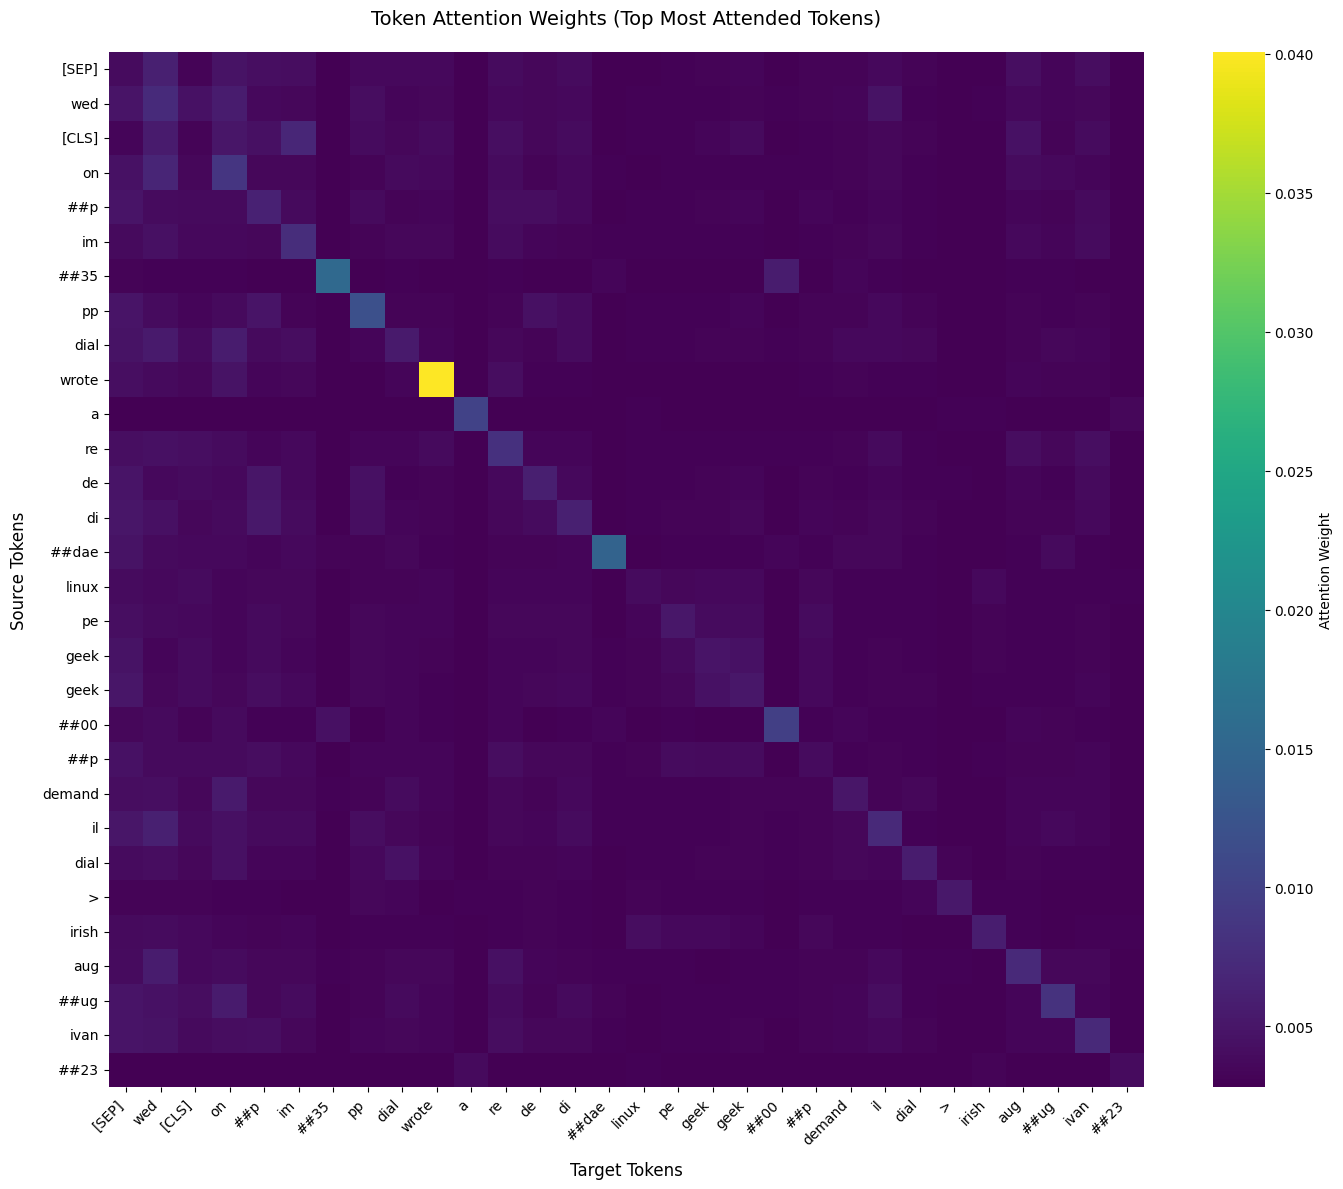


Top token interactions:
'aug' → 'wed': 0.0057
'il' → 'wed': 0.0060
'[SEP]' → 'wed': 0.0061
'on' → 'wed': 0.0067
'[CLS]' → 'im': 0.0068

Top 10 most attended tokens:
'[SEP]': 0.0035
'wed': 0.0034
'[CLS]': 0.0032
'on': 0.0032
'##p': 0.0032
'im': 0.0032
'##35': 0.0032
'pp': 0.0032
'dial': 0.0032
'wrote': 0.0032

Prediction probability: 0.0001

Explanation metrics:
convergence_delta: -0.0129
attribution_mean: -0.0000
attribution_std: 0.0005


In [10]:
from utils.bert_evaluation import analyze_explanations, visualize_attention

# Analyze a sample email
sample_text = test_df['text'].iloc[0]
print("Analyzing text:", sample_text[:100], "...\n")

explanation_data, prob = analyze_explanations(model, sample_text, tokenizer)

# Visualize attention for layer 12
if 'layer_12' in explanation_data:
    print("Visualizing attention weights for layer 12:")
    # Ensure tensor is detached and moved to CPU before converting to numpy
    attention_weights = explanation_data['layer_12'][0].detach().cpu().numpy()
    visualize_attention(sample_text, attention_weights, tokenizer)
else:
    print("Warning: Layer 12 attention weights not available")

# Print prediction and explanation metrics
print(f"\nPrediction probability: {prob:.4f}")
if 'metrics' in explanation_data:
    print("\nExplanation metrics:")
    for metric, value in explanation_data['metrics'].items():
        print(f"{metric}: {value:.4f}")

## 3. Adversarial Robustness Analysis

Implementing adversarial robustness metrics from Section 3.5.4 of the thesis.

In [11]:
from utils.bert_evaluation import evaluate_adversarial_robustness

# Evaluate adversarial robustness
robustness_metrics = evaluate_adversarial_robustness(model, test_df, tokenizer)

for metric, value in robustness_metrics.items():
    print(f"{metric}: {value:.4f}")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

prediction_stability: 0.7603
decision_stability: 0.7600
